## Importing Necessary Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

## Initial Data Analysis

In [2]:
# Importing the original files

customers = pd.read_excel('/home/joao/code/capstone/data/Customers.xlsx')
orders = pd.read_excel('/home/joao/code/capstone/data/Orders.xlsx')

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22625 entries, 0 to 22624
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Customer_ID  22625 non-null  int64 
 1   GENDER       22625 non-null  object
 2   AGE          22625 non-null  int64 
 3   GEOGRAPHY    22625 non-null  object
dtypes: int64(2), object(2)
memory usage: 707.2+ KB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              131706 non-null  int64         
 1   Date            131706 non-null  datetime64[ns]
 2   Customer_ID     131706 non-null  int64         
 3   Transaction_ID  131706 non-null  int64         
 4   SKU_Category    131706 non-null  object        
 5   SKU             131706 non-null  object        
 6   Quantity        131706 non-null  float64       
 7   Sales_Amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 8.0+ MB


In [5]:
# Cleaning the dataset before merging

customers = customers.rename(columns={
    'Customer_ID':'customer_id',
    'GENDER':'gender',
    'AGE':'age',
    'GEOGRAPHY':'country'
})

orders = orders.rename(columns= {
    'Date':'date',
    'Customer_ID':'customer_id',
    'Transaction_ID':'transaction_id',
    'SKU_Category':'sku_category',
    'SKU':'sku',
    'Quantity':'quantity',
    'Sales_Amount':'sales_amount'
})

In [6]:
orders.columns, customers.columns

(Index(['id', 'date', 'customer_id', 'transaction_id', 'sku_category', 'sku',
        'quantity', 'sales_amount'],
       dtype='object'),
 Index(['customer_id', 'gender', 'age', 'country'], dtype='object'))

In [7]:
# Merging the two DataFrames on 'customer_id'
merged_df = pd.merge(orders, customers, on='customer_id', how='inner')

# Display the first few rows of the merged DataFrame
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              131706 non-null  int64         
 1   date            131706 non-null  datetime64[ns]
 2   customer_id     131706 non-null  int64         
 3   transaction_id  131706 non-null  int64         
 4   sku_category    131706 non-null  object        
 5   sku             131706 non-null  object        
 6   quantity        131706 non-null  float64       
 7   sales_amount    131706 non-null  float64       
 8   gender          131706 non-null  object        
 9   age             131706 non-null  int64         
 10  country         131706 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 11.1+ MB


### Data cleaning and transformation

In [8]:
# Function for cleaning the new merged_df 
def process_data(df):
    df = df.replace({
        "gender": {'M': 1, 'F': 0}})
    df['date'] = pd.to_datetime(df['date'])
    df['quantity'] = df['quantity'].astype(int)
    df['sales_amount'] = df['sales_amount'].astype(int)
    return df

In [9]:
df = pd.read_csv('merged_df.csv')
df = process_data(df)
df.head(5)

,id,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,gender,age,country
0,1,2021-01-02,2547,1,X52,0EM7L,1,3,1,43,Greece
1,639,2021-01-04,2547,332,Q4N,MM3E0,1,12,1,43,Greece
2,7800,2021-01-25,2547,3743,X52,885U7,1,4,1,43,Greece
3,7801,2021-01-25,2547,3743,29A,A59HR,3,6,1,43,Greece
4,17633,2021-02-22,2547,8477,L9F,7W8WS,1,11,1,43,Greece


In [10]:
# Droping the 'id' column as it is not used for the analysis
df = df.drop(columns='id', axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            131706 non-null  datetime64[ns]
 1   customer_id     131706 non-null  int64         
 2   transaction_id  131706 non-null  int64         
 3   sku_category    131706 non-null  object        
 4   sku             131706 non-null  object        
 5   quantity        131706 non-null  int64         
 6   sales_amount    131706 non-null  int64         
 7   gender          131706 non-null  int64         
 8   age             131706 non-null  int64         
 9   country         131706 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 10.0+ MB


## Time series analaysis

In [ ]:
# Aggregating sales_amount by date for total sales over time
total_sales_over_time = df.groupby('date').agg({'sales_amount': 'sum'}).reset_index()

# Displaying the first few rows of the aggregated data
total_sales_over_time.head()


# Customer Segmentation

## RFM

Recency (R): How recently a customer has made a purchase. We can calculate this by finding the number of days since a customer's last purchase.

Frequency (F): How often a customer makes a purchase. We can calculate this by counting the number of transactions each customer has made.

Monetary (M): How much money a customer has spent. We can calculate this by summing up the sales amount for each customer.


In [12]:
# Determine the most recent date in the dataset for recency calculation
most_recent_date = df['date'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('customer_id').agg({
    'date': lambda x: (most_recent_date - x.max()).days,  # Recency (days since last purchase)
    'transaction_id': 'nunique',  # Frequency (total number of transactions)
    'sales_amount': 'sum'  # Monetary (total amount of money spent)
}).rename(columns={'date': 'recency', 'transaction_id': 'frequency', 'sales_amount': 'monetary'})

In [14]:
rfm = rfm.reset_index()
rfm

,customer_id,recency,frequency,monetary
0,1,344,1,15
1,2,196,2,22
2,3,364,1,10
3,4,53,2,31
4,5,180,5,78
...,...,...,...,...
22620,22621,22,1,9
22621,22622,16,1,6
22622,22623,11,1,127
22623,22624,30,1,18


In [15]:
# Calculate quartiles for RFM metrics
quartiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quartiles = quartiles.to_dict()

In [16]:
# Functions to assign scores to Recency, Frequency, and Monetary
def r_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def fm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Assigning scores
rfm['r_score'] = rfm['recency'].apply(r_score, args=('recency', quartiles))
rfm['f_score'] = rfm['frequency'].apply(fm_score, args=('frequency', quartiles))
rfm['m_score'] = rfm['monetary'].apply(fm_score, args=('monetary', quartiles))

# Combining scores to create RFM Segment
rfm['rfm_segment'] = rfm['r_score'].map(str) + rfm['f_score'].map(str) + rfm['m_score'].map(str)

In [17]:
# Calculating average values for RFM metrics in each segment
segment_analysis = rfm.groupby('rfm_segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).reset_index()

segment_analysis.columns = ['rfm_segment',
                            'average_recency',
                            'average_frequency',
                            'average_monetary',
                            'count']

In [18]:
# Analyzing the size of each segment
segment_size = rfm['rfm_segment'].value_counts().reset_index()
segment_size.columns = ['rfm_segment', 'size']

In [34]:
segment_analysis.head()

,rfm_segment,average_recency,average_frequency,average_monetary,count
0,111,319.114504,1.00000,5.331767,1703
1,112,318.795473,1.00000,14.447858,1237
2,113,320.589695,1.00000,35.568702,524
3,114,319.058824,1.00000,119.960784,204
4,131,309.044944,2.05618,6.898876,89


In [21]:
rfm.describe()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score
count,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000
mean,11313.000000,161.957878,2.858873,66.967867,2.502851,2.192575,2.494453
std,6531.419256,115.718072,4.000157,148.212099,1.119852,1.264798,1.119566
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,5657.000000,48.000000,1.000000,9.000000,2.000000,1.000000,1.000000
50%,11313.000000,150.000000,1.000000,22.000000,3.000000,1.000000,2.000000
75%,16969.000000,272.000000,3.000000,60.000000,4.000000,3.000000,3.000000
max,22625.000000,364.000000,99.000000,3920.000000,4.000000,4.000000,4.000000


In [22]:
segment_analysis.describe()

,average_recency,average_frequency,average_monetary,count
count,48.000000,48.000000,48.000000,48.000000
mean,160.656080,2.870013,54.117504,471.354167
std,111.232367,2.084268,66.264045,471.320891
min,18.568084,1.000000,5.256347,1.000000
25%,72.298658,1.000000,13.085893,125.750000
50%,134.000000,2.285048,26.551396,378.000000
75%,250.150181,4.170455,58.782652,600.000000
max,320.589695,10.899188,305.318204,2093.000000


## K-Means

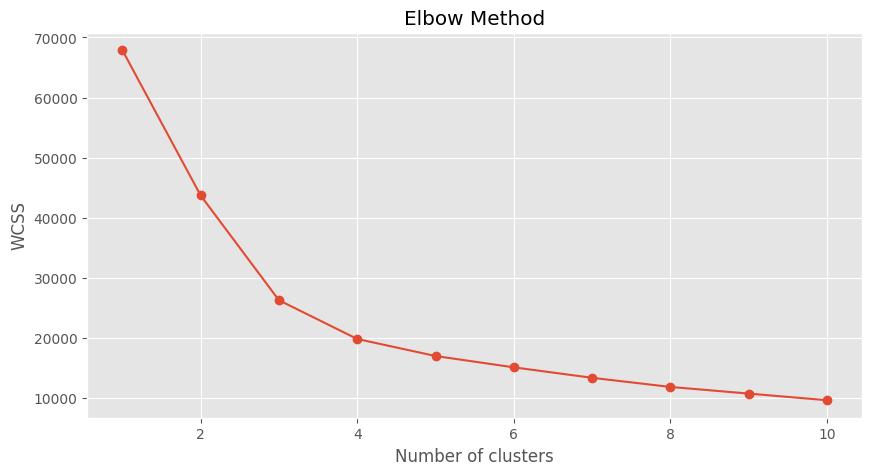

In [23]:
# Normalize the data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
optimal_number_of_clusters = 3

# Fit K-means to the RFM data
kmeans = KMeans(n_clusters=optimal_number_of_clusters, init='k-means++', random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_normalized)

In [27]:
rfm

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,cluster
0,1,344,1,15,1,1,2,112,2
1,2,196,2,22,2,3,2,232,2
2,3,364,1,10,1,1,2,112,2
3,4,53,2,31,3,3,3,333,0
4,5,180,5,78,2,4,4,244,0
...,...,...,...,...,...,...,...,...,...
22620,22621,22,1,9,4,1,1,411,0
22621,22622,16,1,6,4,1,1,411,0
22622,22623,11,1,127,4,1,4,414,0
22623,22624,30,1,18,4,1,2,412,0


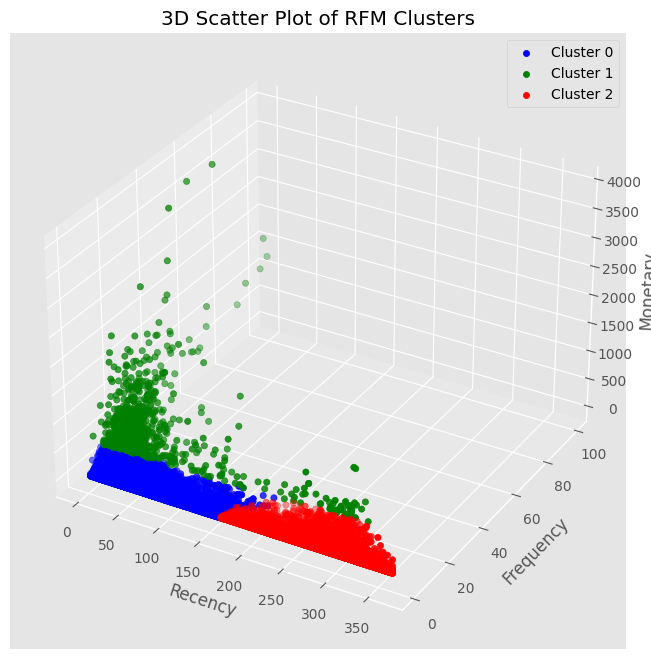

In [28]:
# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Color scheme for clusters
colors = ['blue', 'green', 'red']

# Plot data points
for i in range(optimal_number_of_clusters):
    ax.scatter(
        rfm[rfm['cluster'] == i]['recency'],
        rfm[rfm['cluster'] == i]['frequency'],
        rfm[rfm['cluster'] == i]['monetary'],
        c=colors[i],
        label=f'Cluster {i}'
    )

# Set labels
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters')

# Legend
ax.legend()

- Cluster 0 (blue): Customers with low recency and low to moderate monetary value. These might be lapsed or infrequent customers.
- Cluster 1 (green): Customers with moderate recency and frequency but lower monetary value.
- Cluster 2 (red): Customers who have not made recent purchases and have varying monetary values.

In [29]:
# Calculate descriptive statistics for each cluster
cluster_stats = rfm.groupby('cluster').agg({
    'recency': ['mean', 'median', 'min', 'max'],
    'frequency': ['mean', 'median', 'min', 'max'],
    'monetary': ['mean', 'median', 'min', 'max']
})
cluster_stats

recency                   frequency                   monetary  \
               mean median  min  max       mean median min max        mean   
cluster                                                                      
0         65.006126   57.0    1  199   2.766572    2.0   1  15   53.341410   
1         38.852754   17.0    1  315  16.434322   15.0   2  99  573.460805   
2        271.467610  276.0  162  364   1.760052    1.0   1  13   36.337118   

                          
        median min   max  
cluster                   
0         28.0   0   544  
1        464.0  90  3920  
2         16.0   0   629

In [30]:
# Get the centroids for each cluster
centroids = kmeans.cluster_centers_
centroids

array([[-0.83755346, -0.02331551, -0.0920789 ],
       [-1.06419716,  3.39236661,  3.41517532],
       [ 0.94662169, -0.27471726, -0.20669301]])

- Cluster 0 Centroid: [-0.83755346, -0.02331551, -0.0920789 ]

Could represent a segment of customers who are relatively recent and have an average purchase frequency and slightly lower spending. These might be "everyday" customers who make regular, smaller purchases.

    - Recency: The negative value indicates that customers in this cluster have made purchases more recently than the average customer. The score is closer to zero than Cluster 2's positive value, which suggests they are not the most recent but still relatively recent.
    - Frequency: The value is close to zero, which suggests that customers in this cluster buy as frequently as the average customer.
    - Monetary: The slightly negative value suggests that customers in this cluster spend slightly less than the average customer.

- Cluster 1 Centroid: [-1.06419716, 3.39236661, 3.41517532]

Is likely your most valuable segment, with customers who have purchased very recently, do so very frequently, and spend a lot. These are your high-value, loyal customers.

    - Recency: The most negative value of all clusters for recency indicates that these customers have made purchases more recently than those in the other two clusters.
    - Frequency: The positive value, which is significantly higher than the other clusters, suggests that customers in this cluster make purchases much more frequently than the average customer.
    - Monetary: The positive value, which is also significantly higher, indicates that customers in this cluster spend much more than the average customer.

- Cluster 2 Centroid: [ 0.94662169, -0.27471726, -0.20669301]

Could be at-risk or lapsed customers who haven't made recent purchases, don't buy frequently, and spend less.

    - Recency: The positive value here is the highest among the three clusters, suggesting that these customers have not made purchases as recently as those in the other clusters.
    - Frequency: The negative value, though not as low as Cluster 0, suggests these customers purchase less frequently than the average customer.
    - Monetary: The negative value indicates that customers in this cluster spend less than the average customer.

## Calculating Customer Lifetime Value (CLV)

In [ ]:
# repeat rate = customer with at least 2 transactions / total customers number

# count the number of transactions for each customer_id
transaction_counts = merged_df.groupby('customer_id')['transaction_id'].nunique()

# determine which customers have at least 2 transactions
customer_two_trans = transaction_counts[transaction_counts >= 2].count()

# total number of customers
total_customers = merged_df['customer_id'].nunique()

# repeat rate
repeat_rate  = customer_two_trans / total_customers

print("Repeat rate:", repeat_rate)

In [ ]:
# churn rate = 1 - repat_rate

churn_rate = 1 - repeat_rate
churn_rate

In [ ]:
# average customer lifespan (ACL) = 1 / churn rate

acl = 1 / churn_rate
acl

In [ ]:
# average purchase frequency (APF) = total number of purchases / total customers number

total_purchases = merged_df['transaction_id'].nunique()

apf = total_purchases / total_customers
apf

In [ ]:
# Avg. Purchase Value (APV) = Total Revenue / Total Number of Purchases

total_revenue = merged_df['sales_amount'].sum()

apv = total_revenue / total_purchases
apv

In [ ]:
# customer lifetime value (CLV) = Avg. Purchase Value * Avg. Purchase Frequency * Avg. Customer Lifespan

clv = apv * apf * acl
clv

In [ ]:
# calculate total revenue and number of purchases per customer

customer_revenue = merged_df.groupby('customer_id')['sales_amount'].sum()

# calculating the avg purchase value (apv) per customer_id

customer_apv = customer_revenue / transaction_counts
customer_apv.describe()

In [ ]:
# average customer lifespan
# TO-DO check other approaches to customer lifespan
customer_first_purchase = merged_df.groupby('customer_id')['date'].min()
customer_last_purchase = merged_df.groupby('customer_id')['date'].max()
customer_lifespan = (customer_last_purchase - customer_first_purchase).dt.days
average_customer_lifespan = customer_lifespan.mean()
average_customer_lifespan

In [ ]:
customer_lifespan.plot(kind='hist', bins=5)
plt.show()

In [ ]:
lifespan = customer_lifespan.to_frame(name='lifespan')
lifespan = lifespan.reset_index()
lifespan

In [ ]:
sns.boxplot(data=lifespan['lifespan'])

In [ ]:
# lifepsan.to_csv('rfm2.csv', index=True)

In [ ]:
# clv for each customer

customer_clv = customer_apv * apf * average_customer_lifespan
customer_clv.head()

In [ ]:
customer_clv_df = customer_clv.to_frame(name='clv')
customer_clv_df

In [ ]:
customer_clv_df.reset_index()

In [ ]:
# rfm.to_csv('rfm2.csv', index=True)

In [ ]:
segment_analysis.head(20)

In [ ]:
# .to_csv('rfm1.csv', index=False)

In [ ]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

## Sales Analysis

#### What are the biggest countries in sales amount?

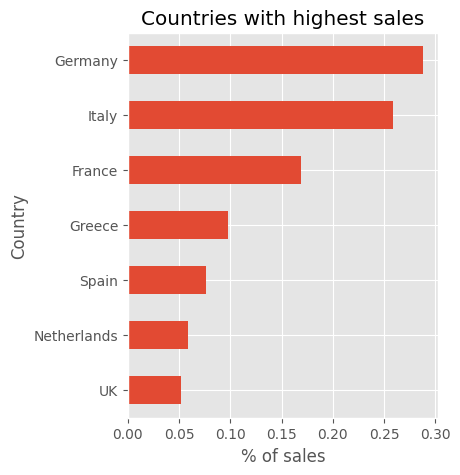

In [31]:
ax = df['country'].value_counts(ascending=True, normalize=True) \
        .plot(kind='barh',
              figsize=(4, 5))

ax.set_ylabel('Country')
ax.set_xlabel('% of sales')
ax.set_title('Countries with highest sales')

plt.show()

## Demographics

### What is the distribution of sales between genders?

Text(0, 0.5, 'Gender')

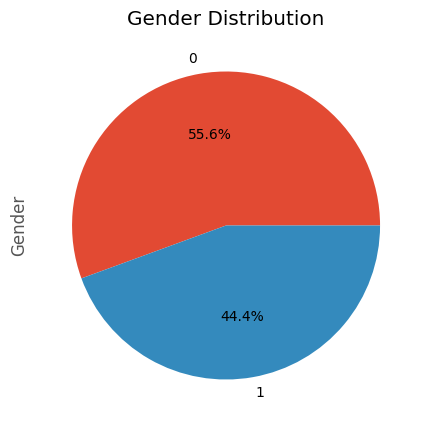

In [32]:
ax = df.groupby('gender')['sales_amount'].sum() \
        .plot(kind='pie',
              autopct='%.1f%%',
              figsize=(5,5))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Gender Distribution')
ax.set_ylabel('Gender')

In [47]:
new_merged_df = pd.merge(merged_df, rfm, how='inner', on='customer_id')
new_merged_df = new_merged_df.drop(columns='id')

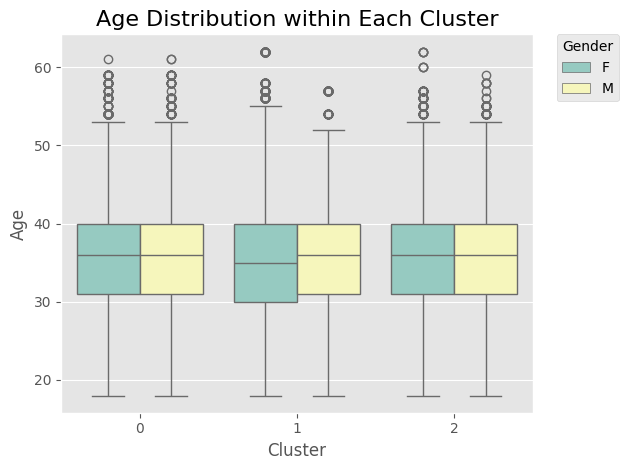

In [53]:
sns.boxplot(data=new_merged_df, x='cluster', y='age', hue='gender', palette='Set3')
plt.title('Age Distribution within Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show plot with improved formatting
plt.tight_layout()
plt.show()

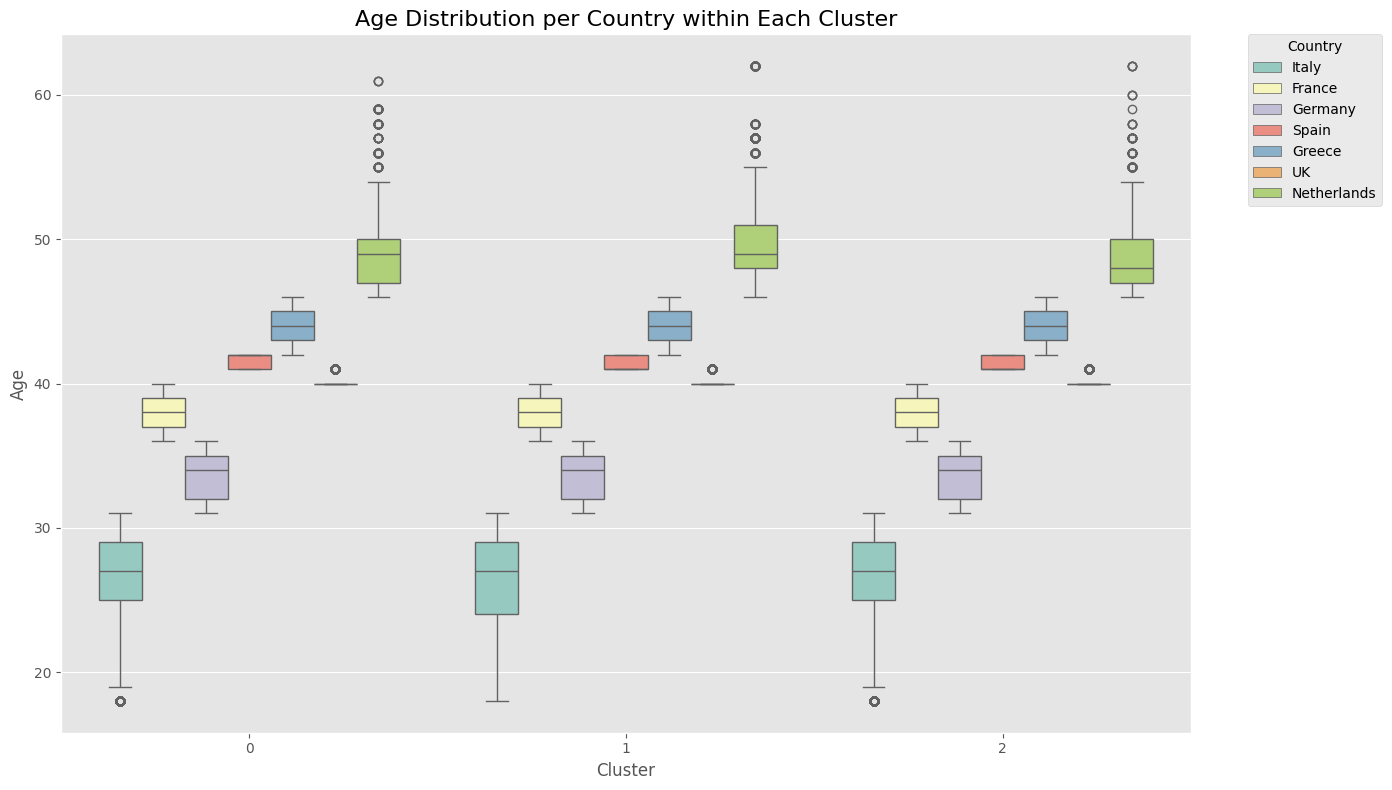

In [52]:
plt.figure(figsize=(14,8))
sns.boxplot(data=new_merged_df, x='cluster', y='age', hue='country', palette='Set3')
plt.title('Age Distribution per Country within Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show plot with improved formatting
plt.tight_layout()
plt.show()

In [6]:
ax = df.groupby('country').agg({'quantity': 'sum',
                                'sales_amount': 'sum'}).reset_index()
                                        
ax.sort_values(by='sales_amount', ascending=False).head(10)

,country,quantity,sales_amount
1,Germany,56274.227,459938.66
3,Italy,50714.712,410646.81
0,France,32621.360,259667.37
2,Greece,19370.000,151657.60
5,Spain,14783.990,119828.15
4,Netherlands,11407.590,92740.61
6,UK,10453.450,83559.42


## Product Analysis

### What are the most sold sku and sku category per country?

product analysis
what are the most sold sku and sku category per country?
what are the average value per sku and sku category, as well as the most and least valuable?
are there any skus or categories that are underperforming?

In [30]:
sku_agg = df.groupby('sku').agg({'quantity': 'sum',
                                'sales_amount': 'sum'}).reset_index()
                                        
sku_agg.sort_values(by='sales_amount', ascending=False).head(5)

,sku,quantity,sales_amount
606,3YDVF,926.0,29419.35
3178,LJ26I,632.0,13571.45
2752,IRQZ4,321.0,11681.63
2071,DWJC4,823.0,10592.09
621,44RUE,218.0,8942.63


In [31]:
sku_cat_agg = df.groupby('sku_category').agg({'quantity': 'sum',
                                        'sales_amount': 'sum'}).reset_index()
sku_cat_agg.sort_values(by='sales_amount', ascending=False).head(5)

,sku_category,quantity,sales_amount
30,6BZ,2833.660,114061.33
155,SJS,2883.330,85142.31
106,LPF,8210.043,84921.91
131,OXH,3884.670,54470.16
119,N8U,12148.000,49119.55


In [32]:
# applying tiers from 0 (lowest) to 9 (highest) to sku_category

sku_category_sales = df.groupby('sku_category')['sales_amount'].sum().reset_index()
sku_category_sales['sales_tier'] = pd.qcut(sku_category_sales['sales_amount'], q=10, labels=False)
sku_category_sales.head(5)

,sku_category,sales_amount,sales_tier
0,01F,38029.87,9
1,06Z,8619.17,7
2,0H2,29875.14,9
3,0KX,2044.45,4
4,0WT,4052.49,6


In [33]:
customer_sales = df.groupby('customer_id')['sales_amount'].sum().reset_index()
customer_sales['customer_tier'] = pd.qcut(customer_sales['sales_amount'], q=10, labels=False)
customer_sales.head(5)

,customer_id,sales_amount,customer_tier
0,1,16.29,3
1,2,22.77,4
2,3,10.92,2
3,4,33.29,5
4,5,78.82,7
